<h1>Assignment 3</h1>

<h2>Due: Tue 28 Jan 2020 Midnight</h2>
<a href='http://www.cs.bgu.ac.il/~elhadad/nlp21.html'>Natural Language Processing - Fall 2021 Michael Elhadad</a>
<p/>
This assignment covers the topic of syntactic parsing.
Submit your solution in the form of a Jupyter notebook (ipynb) file.

<h2>Content</h2>
<ul>
<li><a href="#q1">Q1: Designing CFGs for NLP</a></li>
    <ul>
        <li><a href="#q1.1">Q1.1: Extend a CFG to support Number agreement, Pronouns and Dative Constructions</a>
            <ul>
                <li><a href="#q1.1.1">Q1.1.1 Determiners and Count/Mass Nouns</a></li>
                <li><a href="#q1.1.2">Q1.1.2 Pronouns</a></li>
                <li><a href="#q1.1.3">Q1.1.3 Subject/Verb Agreement</a></li>
                <li><a href="#q1.1.4">Q1.1.4 Over-generation</a></li>
            </ul>            
        </li>
        <li><a href="#q1.2">Q1.2: Extend a CFG to support Coordination and Prepositional Phrases</a>
            <ul>
                <li><a href="#q1.2.1">Q1.2.1 Support Prepositional Phrases</a></li>
                <li><a href="#q1.2.2">Q1.2.2 Support Coordination</a></li>
                <li><a href="#q1.2.3">Q1.2.3 Over-generation</a></li>
            </ul>            
        </li>
    </ul>
</li>
<li><a href="#q2">Q2: Learning a PCFG from a Treebank</a>
    <ul>
        <li><a href="#q2.1">Q2.1 Random PCFG Generation</a>
            <ul>
                <li><a href="#q2.1.1">Q2.1.1 PCFG_Generate</a></li>
                <li><a href="#q2.1.2">Q2.1.2 Generate 1,000 Trees</a></li>
                <li><a href="#q2.1.3">Q2.1.3 Gather Rules Frequency for all Non-Terminals</a></li>
                <li><a href="#q2.1.4">Q2.1.4 Compute KL-Divergence between a priori and generated parameters</a></li>
            </ul>
        </li>
        <li><a href="#q2.2">Q2.2 Learn a PCFG from a Treebank</a>
            <ul>
                <li><a href="#q2.2.1">Q2.2.1 Induce_PCFG</a></li>
                <li><a href="#q2.2.2">Q2.2.2 Data Exploration</a></li>
            </ul>
        </li>
        <li><a href="#q2.3">Q2.3 Induce a PCFG in Chomsky Normal Form</a>
            <ul>
                <li><a href="#q2.3.1">Q2.3.1 PCFG_CNF_Learn</a></li>
                <li><a href="#q2.3.2">Q2.3.2 Data Exploration</a></li>
            </ul>
        </li>
        <li><a href="#q2.4">Q2.4 Test CFG Independence Assumptions</a></li>
    </ul>
</li>
<li><a href="#q3">Q3: Building and Evaluating a Simple PCFG Parser</a>
	<ul>
        <li><a href="#q3.1">Q3.1 Build a Parser</a>
            <ul>
                <li><a href="#q3.1.1">Q3.1.1 Dataset Split</a></li>
                <li><a href="#q3.1.2">Q3.1.2 Learn a PCFG over the Chomsky Normal Form</a></li>
                <li><a href="#q3.1.3">Q3.1.3 Viterbi Parser</a></li>
            </ul>            
        </li>
        <li><a href="#q3.2">Q3.2 Evaluate the Parser</a></li>
        <li><a href="#q3.3">Q3.3 Accuracy per Distance</a></li>
        <li><a href="#q3.4">Q3.4 Accuracy per Label</a></li>
    </ul>
</li>
</ul>

In [6]:
# helper class to print nice outputs
class txt:
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def make_bold(text):
    return txt.BOLD+ text + txt.END

def make_underline(text):
    return txt.UNDERLINE+ text + txt.END

<hr/>
<a name="q1"></a>
<h2>Question 1: Designing CFGs for NLP</h2>

NLTK provides library support to read CFGs from string representation, and parse sentences given a CFG using different 
parsing algorithms (either top-down or bottom-up).  In this question, we manually develop a grammar to support 
increasingly complex phenomena in English syntax. The following code provides the starting point:

In [7]:
import nltk
from nltk import CFG

sg = """
S -> NP VP
VP -> IV | TV NP
NP -> 'John' | "bread"
IV -> 'left'
TV -> 'eats'
"""
g = CFG.fromstring(sg)

# Bottom-up  parser
sr_parser = nltk.ShiftReduceParser(g, trace=2)

# Parse sentences and observe the behavior of the parser
def parse_sentence(sent):
    tokens = sent.split()
    trees = sr_parser.parse(tokens)
    for tree in trees:
        print(tree)

parse_sentence("John left")
parse_sentence("John eats bread")

Parsing 'John left'
    [ * John left]
  S [ 'John' * left]
  R [ NP * left]
  S [ NP 'left' * ]
  R [ NP IV * ]
  R [ NP VP * ]
  R [ S * ]
(S (NP John) (VP (IV left)))
Parsing 'John eats bread'
    [ * John eats bread]
  S [ 'John' * eats bread]
  R [ NP * eats bread]
  S [ NP 'eats' * bread]
  R [ NP TV * bread]
  S [ NP TV 'bread' * ]
  R [ NP TV NP * ]
  R [ NP VP * ]
  R [ S * ]
(S (NP John) (VP (TV eats) (NP bread)))


In this toy grammar, the following non-terminals are used:
<ul>
<li>S: sentence
<li>VP: verb phrase
<li>NP: noun phrase
<li>IV: intransitive verb (a verb which does not expect a complement)
<li>TV: transitive verb (a verb which expects an obligatory complement)
</ul>

<a name="q1.1"></a>
<h3>Question 1.1: Extend a CFG to support Determiners, Number agreement, Countable/Mass nouns, Pronouns and Dative Constructions</h3>

Extend the CFG so that the following sentences can be parsed:
<pre>
    John left
    John loves Mary
    They love Mary
    They love her
    She loves them
    Everybody loves John
    A boy loves Mary
	The boy loves Mary
	Some boys love Mary
    John gave Mary a heavy book
    John gave it to Mary
	John likes butter
	John moves a chair
</pre>

<a name="q1.1.1"></a>
<h4>1.1.1 Determiners and Count/Mass Nouns</h4>

<b>Determiners</b> in English come before common nouns.
Proper nouns cannot have a determiner. (We ignore cases such as "The Petersons came by tonight for a visit.")
<p/>
Some determiners can only be used for singular nouns ("a"), others only for plural nouns ("many") and others with either plural or singular ("the").
<p/>
Some common nouns are called "uncountable" or <a href="https://en.wikipedia.org/wiki/Mass_noun">mass nouns</a> (e.g., "butter").
Mass nouns cannot appear in plural and cannot have counting determiners.
Other nouns are <a href=https://en.wikipedia.org/wiki/Count_noun">countable nouns</a>. They can be used in the plural and can be modified by counting determiners.
<p/>
Extend the grammar to support countable and uncountable nouns with the corresponding restrictions on determiners and plural.
<p/>

We added support in nouns - countable and also uncountables: <br>
Since there is a differance in the way the nouns can "appear" in the sentences, we also need to "talk about them" in a different way, it is incorrect to talk about those nouns the same. For that reason, there are the different deteminers.<br><br>
We added support in determiers, for singular nouns and for plural nouns: <br>
The are words like 'the' that can appear in both, so we added them twice. It may look similar but the sentences differ, and we cannot generalize it to only plural or singular, it will change the meaning or the correctness of the sentences.<br>
To support that we added - SDET, and PDET rules.<br><br>
Also we though it would be meaningful to consider diferrenely sentences like "the girl" and "the beautiful girl", the adjective between the DET and the NOUN changes the sentece, and we cannot ignore this part. <br>
To support that we added SNNOM and PNNOM rules.<br><br>

We then extended NP with the addition DET rules, while separating DET + NOUN and DET + ADJ + NOUN, as explained above.

In [5]:
sg_extend = """
S -> NP VP | 
VP -> IV | TV NP
NP -> SDet SN | PDET PN | SNNOM | PNNOM | 'John' | 'bread' | 'Mary' | 'Everybody' 
IV -> 'left' | 
TV -> 'eats' | 'moves' | 'loves' | 'love' | 'gave' | 'likes'
SDET -> 'a' | 'the' |'A' | 'The'
PDET -> 'Some' | 'the' | 'The'
ADJ -> 'heavy'
SNNOM -> SDET ADJ SN
PNNOM -> PDET ADJ PN
SN -> 'bread' | 'boy' | 'butter' | 'chair' | 'book'
PN -> 'boys'
"""

<a name="q1.1.2"></a>
<h4>1.1.2 Pronouns</h4>

<b>Pronouns</b> in English are characterized by the following morphological attributes:
<ul>
    <li>Number: singular / plural (e.g., he/they)</li>
    <li>Gender: masculine / feminine / neutral (e.g., he/she/it)</li>
    <li>Case: nominative / accusative (e.g., he/him)</li>
</ul>
Make sure the appropriate form of pronouns are used in each of the possible contexts.
Do you need to encode gender in the grammar? Explain why.
<p/>

Pronouns takes the place of a noun, they substitutes for a noun or noun phrase. Hence, they can be singular or plural, with or without gender,  nominative or accusative. And all of these options needs to be taken under consideration in the grammar.<br>
To support these options, we added a few more rules to the grammar:<br>
* PL_PRO - plural pronoun, here we have only 'they' in it.
* SI_PRO_SUBJ - singular pronoun and the subject.
* SI_PRO_OBJ - singular pronoun and the object.

We also added prepositional 'to', because we want to suuport the form 'X gave Y to Z'. And it caused an addition rule for 'S'.

In [6]:
sg_extend = """
S -> NP VP | S PREP NP
VP -> IV | TV NP
NP -> SDET SN | PDET PN | SNNOM | PNNOM | SI_PRO_SUBJ | PL_PRO | SI_PRO_OBJ | SN | PN | 'John' | 'Mary'
IV -> "left"
TV -> 'eats' | 'moves' | 'loves' | 'love' | 'gave' | 'likes'
SDET -> 'a' | 'A' | 'the' | 'The'
PDET -> 'Some' | 'the' | 'The'
SN -> 'bread' | 'boy' | 'butter' | 'chair' | 'book'
PN -> 'boys'
ADJ -> 'heavy'
SNNOM -> SDET ADJ SN
PNNOM -> PDET ADJ PN
PL_PRO -> 'They'
SI_PRO_SUBJ -> 'She' | 'Everybody' | 'it'
SI_PRO_OBJ -> 'her' | 'it' | 'them'
PREP -> 'to'
"""

**Do we need to encode gender in our grammar?<br>**
No, that is because we cannot reach a gender dissagreemnet between the expressinos.<br> Notice that in those sentences, we can say that the gender 'doesn't matter' - of course this is not entirely correct, but if we will replace between female and male (or vice versa) in the wxamples above the sentece will still make perfectly sense.<br>
Notice that we do not have sentences like 'John moves **his** chair' - where the gender matter, and if we will change it to - 'John moves **her** chair' it will not make sense (assuming John is a male). In the English language in general it matters a lot, but here, with those sentences, we do not need to condier it in the grammar.

<a name="q1.1.3"></a>
<h4>1.1.3 Subject/Verb Agreement</h4>
<p/>
Make sure subject and verb agree in number.
<p/>

In [7]:
grammar = CFG.fromstring(sg_extend)
# Bottom-up  parser
sr_parser = nltk.ShiftReduceParser(grammar, trace=2)

Let's take a look - how our grammar handles these sentences.

In [8]:
sentences = [
    'John left',
    'John loves Mary',
    'They love Mary',
    'They love her',
    'She loves them',
    'Everybody loves John',
    'A boy loves Mary',
    'The boy loves Mary',
    'Some boys love Mary',
    'John gave Mary a heavy book',
    'John gave it to Mary',
    'John likes butter',
    'John moves a chair']

for sen in sentences:
    print('\n', sen, ':')
    parse_sentence(sen)


 John left :
Parsing 'John left'
    [ * John left]
  S [ 'John' * left]
  R [ NP * left]
  S [ NP 'left' * ]
  R [ NP IV * ]
  R [ NP VP * ]
  R [ S * ]
(S (NP John) (VP (IV left)))

 John loves Mary :
Parsing 'John loves Mary'
    [ * John loves Mary]
  S [ 'John' * loves Mary]
  R [ NP * loves Mary]
  S [ NP 'loves' * Mary]
  R [ NP TV * Mary]
  S [ NP TV 'Mary' * ]
  R [ NP TV NP * ]
  R [ NP VP * ]
  R [ S * ]
(S (NP John) (VP (TV loves) (NP Mary)))

 They love Mary :
Parsing 'They love Mary'
    [ * They love Mary]
  S [ 'They' * love Mary]
  R [ PL_PRO * love Mary]
  R [ NP * love Mary]
  S [ NP 'love' * Mary]
  R [ NP TV * Mary]
  S [ NP TV 'Mary' * ]
  R [ NP TV NP * ]
  R [ NP VP * ]
  R [ S * ]
(S (NP (PL_PRO They)) (VP (TV love) (NP Mary)))

 They love her :
Parsing 'They love her'
    [ * They love her]
  S [ 'They' * love her]
  R [ PL_PRO * love her]
  R [ NP * love her]
  S [ NP 'love' * her]
  R [ NP TV * her]
  S [ NP TV 'her' * ]
  R [ NP TV SI_PRO_OBJ * ]
  R [ NP 

We can see that the grammar "worked" for the sentences, even though it is pretty specific for thim, and not very sufficticated, it did a nice job recognizing the different part of speech.

<a name="q1.1.4"></a>
<h4>1.1.4 Over-generation</h4>
    
Check whether your grammar overgenerates by giving an example of ungrammatical sentence that it recognizes as grammatical.
<p/>

This sentence doesn't make sense. We know it since we undersatnd English and have some common sense and can tell that "heavy likes" is not really understood...

But, our grammar can't tell that. It looks if there exist rules to analyze the sentence, and there are (because - without meaning to include ungrammatical sentences, we, unfortunately, wrote them before, of course). <br>
Every sequence of words here can be understood by the grammar we wrote, and this is the reason the grammar recognizes this sentence as grammatical.

In [9]:
ungrammatical = "John gave Mary a heavy likes"
parse_sentence(ungrammatical)

Parsing 'John gave Mary a heavy likes'
    [ * John gave Mary a heavy likes]
  S [ 'John' * gave Mary a heavy likes]
  R [ NP * gave Mary a heavy likes]
  S [ NP 'gave' * Mary a heavy likes]
  R [ NP TV * Mary a heavy likes]
  S [ NP TV 'Mary' * a heavy likes]
  R [ NP TV NP * a heavy likes]
  R [ NP VP * a heavy likes]
  R [ S * a heavy likes]
  S [ S 'a' * heavy likes]
  R [ S SDET * heavy likes]
  S [ S SDET 'heavy' * likes]
  R [ S SDET ADJ * likes]
  S [ S SDET ADJ 'likes' * ]
  R [ S SDET ADJ TV * ]


<a name="q1.2"></a>
<h3>Question 1.2: Extend a CFG to support Coordination and Prepositional Phrases</h3>

<a name="q1.2.1"></a>
<h4>1.2.1 Support Prepositional Phrases</h4>

Extend the grammar so that it can parse the following sentences:

<pre>
John saw a man with a telescope
John saw a man on the hill with a telescope

Mary knows men and women
Mary knows men, children and women

John and Mary eat bread
John and Mary eat bread with cheese
</pre>

We now need to extend our grammar.<br> These sentences make the grammar be more 'reach'. We will have now more options of forms to sentences.<br> We will support conjunction, more prepositional options, and therefore we extend the 'NP' list of rules and also 'S' list of rules.<br>
Notice that in the grammar we also have repeating words in different rules. For example 'the' appears in the singular determiner but also in the plural determiner. 'knows' appears in the TV and also IV, because we can say 'she knows.' (in the correct context, e.g - a conversation) but also 'Mary knows the secret' and it makes sense in both ways.

In [10]:
sg_extend2 = """
S -> NP VP | S PREP NP | S CONJ NP
VP -> IV | TV NP
NP -> NP CONJ NP | SDET SN | PDET PN | SNNOM | PNNOM | SI_PRO_SUBJ | PL_PRO | SI_PRO_OBJ | SN | PN | 'John' | 'Mary'
IV -> 'left' | 'eat' | 'knows'
TV -> 'eats' | 'moves' | 'loves' | 'love' | 'gave' | 'likes' | 'eat' | 'saw' | 'knows'
SDET -> 'a' | 'A' | 'the' | 'The'
PDET -> 'Some' | 'the' | 'The'
SN -> 'bread' | 'boy' | 'butter' | 'chair' | 'book' | 'telescope' | 'hill' | 'cheese' | 'man'
PN -> 'boys' | 'men' | 'women' | 'children'
ADJ -> 'heavy'
SNNOM -> SDET ADJ SN
PNNOM -> PDET ADJ PN
PL_PRO -> 'They'
SI_PRO_SUBJ -> 'She' | 'Everybody' | 'it'
SI_PRO_OBJ -> 'her' | 'it' | 'them'
PREP -> 'to' | 'with' | 'on'
CONJ -> 'and' | ','
"""

In [11]:
grammar2 = CFG.fromstring(sg_extend2)
# Bottom-up  parser
sr_parser = nltk.ShiftReduceParser(grammar2, trace=2)

In [12]:
sentences = [
    'John saw a man with a telescope',
    'John saw a man on the hill with a telescope',
    'Mary knows men and women',
    'Mary knows men children and women',
    'John and Mary eat bread',
    'John and Mary eat bread with cheese']

for sen in sentences:
    print('\n', sen, ':')
    parse_sentence(sen)


 John saw a man with a telescope :
Parsing 'John saw a man with a telescope'
    [ * John saw a man with a telescope]
  S [ 'John' * saw a man with a telescope]
  R [ NP * saw a man with a telescope]
  S [ NP 'saw' * a man with a telescope]
  R [ NP TV * a man with a telescope]
  S [ NP TV 'a' * man with a telescope]
  R [ NP TV SDET * man with a telescope]
  S [ NP TV SDET 'man' * with a telescope]
  R [ NP TV SDET SN * with a telescope]
  R [ NP TV NP * with a telescope]
  R [ NP VP * with a telescope]
  R [ S * with a telescope]
  S [ S 'with' * a telescope]
  R [ S PREP * a telescope]
  S [ S PREP 'a' * telescope]
  R [ S PREP SDET * telescope]
  S [ S PREP SDET 'telescope' * ]
  R [ S PREP SDET SN * ]
  R [ S PREP NP * ]
  R [ S * ]
(S
  (S (NP John) (VP (TV saw) (NP (SDET a) (SN man))))
  (PREP with)
  (NP (SDET a) (SN telescope)))

 John saw a man on the hill with a telescope :
Parsing 'John saw a man on the hill with a telescope'
    [ * John saw a man on the hill with a teles

<a name="q1.2.2"></a>
<h4>1.2.2 Support Coordination</h4>
    
What is the number of a coordination such as "John and Mary"?
<p/>
What is the number of a coordination such as "John or Mary"?
<p/>
"John or the children"?
<p/>
Propose (without implementing) ways to support such variations.
<p/>

The number of coordination will always be plural, in all cases above.<br>
A plural subject could appear along with plural noun (one or more), or several singular nouns, added together, in coordination.<br><br>
We support in our grammar expressions from the form X **and** Y. In the same way, we could implement Z **or** W. And equaly we coud also add T **and the** S. But here we must also check that S can appear with determiner before (and we added support to that part, in the first question).



<a name="q1.2.3"></a>
<h4>1.2.3 Overgeneration</h4>

Demonstrate ways in which your grammar over-generates.  Explain your observations.
<p/>

In [13]:
parse_sentence('Mary loves')

Parsing 'Mary loves'
    [ * Mary loves]
  S [ 'Mary' * loves]
  R [ NP * loves]
  S [ NP 'loves' * ]
  R [ NP TV * ]


'loves' is transitive verb, so it should appear with an obligatory complement right after it. But our grammar accept it as a proper sentence.

In [14]:
parse_sentence('John likes moves a chair')

Parsing 'John likes moves a chair'
    [ * John likes moves a chair]
  S [ 'John' * likes moves a chair]
  R [ NP * likes moves a chair]
  S [ NP 'likes' * moves a chair]
  R [ NP TV * moves a chair]
  S [ NP TV 'moves' * a chair]
  R [ NP TV TV * a chair]
  S [ NP TV TV 'a' * chair]
  R [ NP TV TV SDET * chair]
  S [ NP TV TV SDET 'chair' * ]
  R [ NP TV TV SDET SN * ]
  R [ NP TV TV NP * ]
  R [ NP TV VP * ]


This sentence does makes sense, but it is not a proper way to say it. We would aexpect it to be more like 'John likes moving chairs/ the chair/'. There is discrepancies between the two present simple verbs that follow each other.

In [15]:
parse_sentence('boy with the boy')

Parsing 'boy with the boy'
    [ * boy with the boy]
  S [ 'boy' * with the boy]
  R [ SN * with the boy]
  R [ NP * with the boy]
  S [ NP 'with' * the boy]
  R [ NP PREP * the boy]
  S [ NP PREP 'the' * boy]
  R [ NP PREP SDET * boy]
  S [ NP PREP SDET 'boy' * ]
  R [ NP PREP SDET SN * ]
  R [ NP PREP NP * ]


In [16]:
print(parse_sentence('John likes moves a chair'))

Parsing 'John likes moves a chair'
    [ * John likes moves a chair]
  S [ 'John' * likes moves a chair]
  R [ NP * likes moves a chair]
  S [ NP 'likes' * moves a chair]
  R [ NP TV * moves a chair]
  S [ NP TV 'moves' * a chair]
  R [ NP TV TV * a chair]
  S [ NP TV TV 'a' * chair]
  R [ NP TV TV SDET * chair]
  S [ NP TV TV SDET 'chair' * ]
  R [ NP TV TV SDET SN * ]
  R [ NP TV TV NP * ]
  R [ NP TV VP * ]
None


This phrase can be recursive. We can understand that it is about two boys, but it is not entirely understood, it depands on the re of the sentnce if the meaning is clear or not.

Over-generation happens when the rules of the language allows us to constract sentences that are fully well-formed, but are not natural in the language, the sound wrong to a native speaker of the language.
That is the reason that our grammar produced over-generation, those sentences we showed as examples above make sense, but they are just not written in a proper way for the language.

<hr/>
<a name="q2"></a>
<h2>Question 2: Learning a PCFG from a Treebank</h2>

<a name="q2.1"></a>
<h3>Question 2.1: Random PCFG Generation</h3>

Consider the PCFG datatype implementation provided in NLTK.
<p/>
Consider the module <a href="http://www.nltk.org/_modules/nltk/parse/generate.html">nltk.parse.generate</a>.
It contains a function generate(grammar) which given a CFG grammar produces all the sentences the grammar can produce.
Naturally, this may produce an infinite number of sentences if the grammar is recursive.

In [9]:
import itertools
from nltk.grammar import CFG
from nltk.parse import generate

demo_grammar = """
  S -> NP VP
  NP -> Det N
  PP -> P NP
  VP -> 'slept' | 'saw' NP | 'walked' PP
  Det -> 'the' | 'a'
  N -> 'man' | 'park' | 'dog'
  P -> 'in' | 'with'
"""
grammar = CFG.fromstring(demo_grammar)

for n, sent in enumerate(generate.generate(grammar, n=10), 1):
        print('%3d. %s' % (n, ' '.join(sent)))

  1. the man slept
  2. the man saw the man
  3. the man saw the park
  4. the man saw the dog
  5. the man saw a man
  6. the man saw a park
  7. the man saw a dog
  8. the man walked in the man
  9. the man walked in the park
 10. the man walked in the dog


<a name="q2.1.1"></a>
<h4>2.1.1 PCFG_Generate</h4>

Write a new function <code>pcfg_generate(grammar)</code> which will
generate a random tree from a PCFG according to its generative
probability model.  In other words, your task is to write a <code>sample</code>
method from the PCFG distribution.
<p/>

Generation works top down: pick the start symbol of
the grammar, then randomly choose a production starting from the start
symbol, and add the RHS as children of the root node, then expand each
node until you obtain terminals.  The result should be a tree and not
a sentence.
<p/>

The generated parse trees should exhibit the distribution of non-terminal
distributions captured in the PCFG (that is, the generation process should
sample rules according to the weights of each non-terminal in the grammar).
<p/>

Note: you must generate according to the PCFG distribution - not just randomly.
To this end, you should use the method <code>generate()</code> from the
NTLK <a href="http://www.nltk.org/_modules/nltk/probability.html">ProbDistI</a> interface.
Specifically, you should use the
<a href="http://www.nltk.org/api/nltk.html#nltk.probability.DictionaryProbDist">nltk.probability.DictionaryProbDist</a>
class to represent the probability distribution of mapping an LHS non-terminal to one of the possible RHS.

<pre class="prettyprint">
Function Specification

pcfg_generate(grammar) -- return a tree sampled from the language described by the PCFG grammar
</pre>

In [11]:
def sample(productions):  
    dict = {}
    for pr in productions: dict[pr.rhs()] = pr.prob()
    probDist = DictionaryProbDist(dict)
    return probDist.generate()

In [10]:
from nltk import Tree
from nltk.probability import DictionaryProbDist
from nltk.grammar import Nonterminal
from nltk.probability import DictionaryProbDist

def pcfg_generate(grammer,start_symbol=None,index=1):
    if start_symbol is None:
    #     first, we pick the start symbol of the grammer
        start_symbol=grammar.start()
    #     add start symbol as the tree root
    tree = Tree.fromstring('('+str(start_symbol)+')')    
#     then randomly choose a production starting from the start symbol
    productions = grammer.productions()
    productions = grammer.productions(Nonterminal(str(start_symbol)))
    
    #      if we obtain terminals we stop
    if productions==[]:
        return tree
   
    rhs=sample(productions)
#     add the RHS as children of the root node
    for r in rhs:
        tree.insert(index,pcfg_generate(grammer,r,index))
        index+=1   
    return tree

Let's check if we successfuly generate tree

In [20]:
from nltk.grammar import toy_pcfg2
tree=pcfg_generate(toy_pcfg2)
print(tree)

(S
  (NP
    (NP (Name (Bob )))
    (PP
      (P (under ))
      (NP
        (NP (Name (Jack )))
        (PP
          (P (with ))
          (NP
            (NP (Det (the )) (N (boy )))
            (PP (P (with )) (NP (Name (Bob )))))))))
  (VP (V (ran ))))


In [21]:
from nltk.grammar import Nonterminal
from nltk.grammar import toy_pcfg2
from nltk.probability import DictionaryProbDist

productions = toy_pcfg2.productions()
# Get all productions with LHS=NP
np_productions = toy_pcfg2.productions(Nonterminal('NP'))

# sampling
dict = {}
for pr in np_productions: dict[pr.rhs()] = pr.prob()
np_probDist = DictionaryProbDist(dict)

# Each time you call, you get a random sample
print(np_probDist.generate())

print(np_probDist.generate())

print(np_probDist.generate())


(Det, N)
(Name,)
(NP, PP)


<a name="q2.1.2"></a>
<h4>2.1.2 Generate 1,000 Trees</h4>

Generate 1,000 random trees using nltk.grammar.toy_pcfg2 - store the resulting trees in a file "toy_pcfg2.gen".

In [22]:
from nltk.grammar import toy_pcfg2
file = open('toy_pcfg2.gen', "w",encoding="utf-8")
for i in range(1000):
    tree = pcfg_generate(toy_pcfg2)
    file.write(str(tree))

Let's check one tree from the trees

In [23]:
file = open('toy_pcfg2.gen')
# we split trees by the 'S' which i
start_symbol=toy_pcfg2.start()
start_symbol_str='('+str(start_symbol)
trees =  [start_symbol_str + t for t in file.read().split(start_symbol_str)][1:]

# Test if we succeed
print(make_bold('numer of trees we generate: '),len(trees))
print(make_bold ('example for one tree: ') ,trees[1])
trees=[Tree.fromstring(t) for t in trees]

numer of trees we generate:  1000
example for one tree:  (S
  (NP (Name (Jack )))
  (VP
    (V (saw ))
    (NP
      (NP (Name (Jack )))
      (PP (P (under )) (NP (Det (my )) (N (hill )))))))


<a name="q2.1.3"></a>
<h4>2.1.3 Gather Rules Frequency for all Non-Terminals</h4>
    
Compute the rules frequency distribution of each non-terminal and pre-terminal in the generated corpus.
You can look at the code of <a href="http://www.nltk.org/_modules/nltk/grammar.html#induce_pcfg">nltk.induce_pcfg(root, productions)</a> to see how this can be done.
You should construct one distribution per non-terminal.

In [12]:
from nltk.grammar import ProbabilisticProduction
from nltk.probability import FreqDist

def gather_rules_frequency(productions):
    # This part of the example took from the code you gave us
    # Production count: the number of times a given production occurs
    pcount = {}

    # LHS-count: counts the number of times a given lhs occurs
    lcount = {}

    for prod in productions:
        lcount[prod.lhs()] = lcount.get(prod.lhs(), 0) + 1
        pcount[prod] = pcount.get(prod, 0) + 1
            
    prods = [
        ProbabilisticProduction(p.lhs(), p.rhs(), prob=pcount[p] / lcount[p.lhs()])
        for p in pcount]

#    construct one distribution per non-terminal.
    return prods,lcount

In [25]:
def combine_tree_production(trees):
    production=[]
    for t in trees:
        production+=t.productions()
    return production

In [26]:
#  construct one distribution per non-terminal.
def prods_per_lhs(lhs,productions):
    return [p for p in productions if p.lhs()==lhs and p.rhs()!=()]

Let's check on one tree

In [27]:
prods,lcount=gather_rules_frequency(tree[1].productions())
for p in prods:
    print(p)

VP -> V [1.0]
V -> saw [1.0]
saw ->  [1.0]


In [28]:
for lhs in lcount:
    prods_per_label=prods_per_lhs(lhs,prods)
    if prods_per_label==[]:
        continue
    print(make_bold("lhs:"),lhs,make_bold(" rules:"),prods_per_label)

lhs: VP  rules: [VP -> V [1.0]]
lhs: V  rules: [V -> saw [1.0]]


and on more than one tree

In [29]:
list_of_trees=[trees[1],trees[2],trees[3]]
products=combine_tree_production(list_of_trees)

prods,_=gather_rules_frequency(products)
for p in prods:
    print(p)

S -> NP VP [1.0]
NP -> Name [0.5]
Name -> Jack [0.75]
Jack ->  [1.0]
VP -> V NP [1.0]
V -> saw [0.333333]
saw ->  [1.0]
NP -> NP PP [0.125]
PP -> P NP [1.0]
P -> under [1.0]
under ->  [1.0]
NP -> Det N [0.375]
Det -> my [0.666667]
my ->  [1.0]
N -> hill [0.666667]
hill ->  [1.0]
V -> ate [0.666667]
ate ->  [1.0]
Name -> Bob [0.25]
Bob ->  [1.0]
Det -> the [0.333333]
the ->  [1.0]
N -> telescope [0.333333]
telescope ->  [1.0]


get production to the entire 1000 trees

In [30]:
all_products=combine_tree_production(trees)
all_probs,lcount=gather_rules_frequency(all_products)

<a name="q2.1.4"></a>
<h4>2.1.4 Compute KL-Divergence between a priori and generated parameters</h4>
    
For each distribution, compute the KL-divergence between the MLE estimation of the probability
distribution constructed on your test corpus and toy_pcfg2.
The MLE estimation is obtained by applying the <a href="http://www.nltk.org/_modules/nltk/probability.html#MLEProbDist">MLEProbDist</a> estimator to the observed empirical frequency distribution.
KL-divergence (<a href="http://en.wikipedia.org/wiki/Kullback-Leibler_divergence">Kullback-Leibler divergence</a>
also known as relative entropy) estimates the difference between two distributions.
<p/>
Read some precisions on handling <a href='KL.html'>diverging KL computations</a> when the support of the 2 distributions p and q are not identical.
<p/>

Explain your observations.

In [93]:
import math
def compute_KL(prods_origin,prods_sampled):
    kl_total=0
    epsilon = 0.0001
    for lhs in lcount:
        kl=0
        lhs_productions_sample=prods_per_lhs(lhs,prods_sampled.samples())
        if lhs_productions_sample==[]:
            continue
        lhs_productions_origin=prods_per_lhs(lhs, prods_origin.samples())
        qc = (len(lhs_productions_origin) - len(lhs_productions_sample)) * epsilon / len(lhs_productions_sample)
        pc = (len(lhs_productions_origin) - len(lhs_productions_sample)) * epsilon / len(lhs_productions_origin)

        
        for origin_prod in lhs_productions_origin:
            p = origin_prod.prob()-pc
            sampled_prod = next((prod for prod in lhs_productions_sample if prod.lhs() == origin_prod.lhs()
                                 and prod.rhs() == origin_prod.rhs()), None)
            if sampled_prod == None:
                q = epsilon
            else:
                q = sampled_prod.prob()-qc
            
            kl += q * abs(math.log(q/p))
        
        kl_total+=kl    
        print(make_bold("lhs: "), lhs,make_bold("| kl-divergence: "), kl)

In [94]:
compute_KL(MLEProbDist(FreqDist(toy_pcfg2.productions())),
                      MLEProbDist(FreqDist(all_probs)))

lhs:  S | kl-divergence:  0.0
lhs:  NP | kl-divergence:  0.012453642941441929
lhs:  Det | kl-divergence:  0.002429527433932893
lhs:  N | kl-divergence:  0.0037024682545031768
lhs:  VP | kl-divergence:  0.022464807305833022
lhs:  V | kl-divergence:  0.0024124063138587226
lhs:  Name | kl-divergence:  0.0017032785101465503
lhs:  PP | kl-divergence:  0.0
lhs:  P | kl-divergence:  0.0016984775882279142


**Explanation of our observations:**
kl-divergence is a measure of how one probability distribution is different from a second. We can tell that the kl-divergence is relately small , meaning we succeeded to genreate a very close distribution!

<a name="q2.2"></a>
<h3>Question 2.2: Learn a PCFG from a Treebank</h3>

In this question, we will learn a PCFG from a treebank with different
types of tree annotations.  We start from a subset of 200 trees from
the Penn Treebank (which is distributed by <a href="http://www.nltk.org">NLTK</a>
in the corpus named "treebank" - the NLTK version contains about 4,000 trees).
<p/>

In this question, we want to induce a PCFG from the treebank and
investigate its properties.  For reference, NLTK provides a function
called <a href="http://www.nltk.org/_modules/nltk/grammar.html#induce_pcfg">induce_pcfg</a>
in the nltk.grammar module.  It starts from a set of productions and constructs a weighted grammar with the MLE
estimation of the production distributions.


<a name="q2.2.1"></a>
<h4>2.2.1 Induce_PCFG</h4>

At this stage, we learn the PCFG "as is" -- without Chomsky Form Normalization -- but with "simplified" tags. 
That is, we must use a function to simplify all tags in the tree (non-terminal and terminal): 

In [4]:
import nltk
nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\Shani\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [5]:
from nltk.corpus import LazyCorpusLoader, BracketParseCorpusReader

def simplify_functional_tag(tag):
    if '-' in tag:
        tag = tag.split('-')[0]
    return tag

treebank = LazyCorpusLoader('treebank/combined', BracketParseCorpusReader, r'wsj_.*\.mrg')

# Raw form
print(treebank.parsed_sents()[:1])

# Pretty print
print(treebank.parsed_sents()[0])
# we need to transform the tree to remove NONE tags and simplify tags.

[Tree('S', [Tree('NP-SBJ', [Tree('NP', [Tree('NNP', ['Pierre']), Tree('NNP', ['Vinken'])]), Tree(',', [',']), Tree('ADJP', [Tree('NP', [Tree('CD', ['61']), Tree('NNS', ['years'])]), Tree('JJ', ['old'])]), Tree(',', [','])]), Tree('VP', [Tree('MD', ['will']), Tree('VP', [Tree('VB', ['join']), Tree('NP', [Tree('DT', ['the']), Tree('NN', ['board'])]), Tree('PP-CLR', [Tree('IN', ['as']), Tree('NP', [Tree('DT', ['a']), Tree('JJ', ['nonexecutive']), Tree('NN', ['director'])])]), Tree('NP-TMP', [Tree('NNP', ['Nov.']), Tree('CD', ['29'])])])]), Tree('.', ['.'])])]
(S
  (NP-SBJ
    (NP (NNP Pierre) (NNP Vinken))
    (, ,)
    (ADJP (NP (CD 61) (NNS years)) (JJ old))
    (, ,))
  (VP
    (MD will)
    (VP
      (VB join)
      (NP (DT the) (NN board))
      (PP-CLR (IN as) (NP (DT a) (JJ nonexecutive) (NN director)))
      (NP-TMP (NNP Nov.) (CD 29))))
  (. .))


We want all tags of the form "NP-SBJ-2" to be simplified into "NP".  We also want to filter out "NONE" elements from the treebank.  
You must find the best way to perform NONE filtering on the trees. (NONE elements appear in the original Penn Treebank for example in the case of relative clauses.)

<pre class="prettyprint">
pcfg_learn(treebank, n)
-- treebank is the nltk.corpus.treebank lazy corpus reader
-- n indicates the number of trees to read
-- return an nltk.PCFG instance
</pre>

Use the following code as a starting point:

In [3]:
from nltk.grammar import Production
from nltk import Tree, Nonterminal

def get_tag(tree):
    if isinstance(tree, Tree):
        return Nonterminal(simplify_functional_tag(tree.label()))
    else:
        return tree

def tree_to_production(tree):
    return Production(get_tag(tree), [get_tag(child) for child in tree])

def tree_to_productions(tree):
    yield tree_to_production(tree)
    for child in tree:
        if isinstance(child, Tree):
            for prod in tree_to_productions(child):
                yield prod

In [2]:
def simplfy_and_remove_NONE(tree):
    if isinstance(tree, Tree):
        label = tree.label()
        simplify_label = simplify_functional_tag(label)
        tree.set_label(simplify_label)
        
        index = 0
        while index < len(tree):
            if isinstance(tree[index], Tree):
                if tree[index].label == '-NONE-':
                    del tree[index]
                    index = index-1
                else:
                    simplfy_and_remove_NONE(tree[index]) 
                    if len(tree[index]) == 0:
                        del tree[index]
                        index = index - 1
            index += 1

In [1]:
def pcfg_learn(treebank, n):
    productions = []
    for i in range(n):
        tree = treebank.parsed_sents()[i]
        simplfy_and_remove_NONE(tree)
        productions += tree.productions()
    
    print(make_bold('total prods:'), len(productions))
    pcfg = nltk.grammar.induce_pcfg(nltk.grammar.Nonterminal('S'), productions)
    print(make_bold('unique prods:'), len(pcfg.productions()))
    return pcfg

In [38]:
# lets check on one tree
treebank = LazyCorpusLoader('treebank/combined', BracketParseCorpusReader, r'wsj_.*\.mrg')
print(pcfg_learn(treebank, 1))

total prods: 29
unique prods: 28
Grammar with 28 productions (start state = S)
    S -> NP VP . [1.0]
    NP -> NP , ADJP , [0.166667]
    NP -> NNP NNP [0.166667]
    NNP -> 'Pierre' [0.333333]
    NNP -> 'Vinken' [0.333333]
    , -> ',' [1.0]
    ADJP -> NP JJ [1.0]
    NP -> CD NNS [0.166667]
    CD -> '61' [0.5]
    NNS -> 'years' [1.0]
    JJ -> 'old' [0.5]
    VP -> MD VP [0.5]
    MD -> 'will' [1.0]
    VP -> VB NP PP NP [0.5]
    VB -> 'join' [1.0]
    NP -> DT NN [0.166667]
    DT -> 'the' [0.5]
    NN -> 'board' [0.5]
    PP -> IN NP [1.0]
    IN -> 'as' [1.0]
    NP -> DT JJ NN [0.166667]
    DT -> 'a' [0.5]
    JJ -> 'nonexecutive' [0.5]
    NN -> 'director' [0.5]
    NP -> NNP CD [0.166667]
    NNP -> 'Nov.' [0.333333]
    CD -> '29' [0.5]
    . -> '.' [1.0]


In [39]:
# now lets check all 200 trees
treebank = LazyCorpusLoader('treebank/combined', BracketParseCorpusReader, r'wsj_.*\.mrg')
print(pcfg_learn(treebank, 200))

total prods: 9020
unique prods: 2347
Grammar with 2347 productions (start state = S)
    S -> NP VP . [0.212632]
    NP -> NP , ADJP , [0.00113122]
    NP -> NNP NNP [0.0469457]
    NNP -> 'Pierre' [0.00173913]
    NNP -> 'Vinken' [0.00347826]
    , -> ',' [1.0]
    ADJP -> NP JJ [0.08]
    NP -> CD NNS [0.0113122]
    CD -> '61' [0.004329]
    NNS -> 'years' [0.0450161]
    JJ -> 'old' [0.0195312]
    VP -> MD VP [0.0648012]
    MD -> 'will' [0.489796]
    VP -> VB NP PP NP [0.00147275]
    VB -> 'join' [0.00917431]
    NP -> DT NN [0.0774887]
    DT -> 'the' [0.514151]
    NN -> 'board' [0.00609756]
    PP -> IN NP [0.806576]
    IN -> 'as' [0.0242991]
    NP -> DT JJ NN [0.0248869]
    DT -> 'a' [0.20283]
    JJ -> 'nonexecutive' [0.0078125]
    NN -> 'director' [0.00457317]
    NP -> NNP CD [0.00395928]
    NNP -> 'Nov.' [0.00347826]
    CD -> '29' [0.004329]
    . -> '.' [1.0]
    NNP -> 'Mr.' [0.0243478]
    VP -> VBZ NP [0.0353461]
    VBZ -> 'is' [0.386364]
    NP -> NP PP [0.1

<a name="q2.2.2"></a>
<h4>2.2.2 Data Exploration and Validation</h4>

Explore the following properties of the learned PCFG:
<ul>
<li>How many productions are learned from the trees? How many interior nodes were in the treebank?
<li>Draw a plot of the distribution of productions according to their frequency (number of rules with frequency 1, 2, ...).  What do you observe?
<li>Induce a PCFG from 200 trees, and another one from 400 trees - compare the distribution of the rules you learn.
</ul>

In [18]:
def get_non_terminals(productions):
    non_terminals = []
    for p in productions:
        lhs = str(p.lhs()) # get production's left hand 
        lhs = lhs.split(' ')
        for symbol in lhs:
            non_terminals.append(symbol)
    return non_terminals

In [19]:
from collections import Counter
def rules_frequencies_trebank(treebank, n):
    tree_productions = []
    for i in range(n):
        for p in tree_to_productions(treebank.parsed_sents()[i]): tree_productions.append(p)
    prodcutions_counts = Counter(tree_productions)
    freq = []
    for p in prodcutions_counts:
        freq.append(prodcutions_counts[p])
    return freq

In [20]:
import matplotlib.pyplot as plt

def get_statistics(pcfg,n):
    print(make_bold(f'Statistics for n={n}:'))
    productions = pcfg.productions()
    non_terminals=get_non_terminals(productions)
    
    print(make_bold('Number of interior nodes: '),len(set(non_terminals)))
    # plot distribution 
    freq = rules_frequencies_trebank(treebank, n)
    hist = plt.hist(x=freq, bins=range(1,30), alpha=0.7)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Number of Appearnces')
    plt.ylabel('Frequency')
    plt.title('Distribution of productions ')
    return pcfg

total prods: 9020
unique prods: 2347
Statistics for n=200:
Number of interior nodes:  58


<Grammar with 2347 productions>

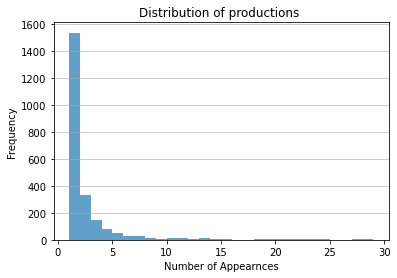

In [43]:
pcfg200=pcfg_learn(treebank, 200)
get_statistics(pcfg200,200)

total prods: 17665
unique prods: 3847
Statistics for n=400:
Number of interior nodes:  62


<Grammar with 3847 productions>

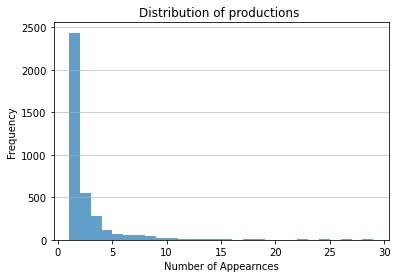

In [44]:
pcfg400=pcfg_learn(treebank, 400)
get_statistics(pcfg400,400)

<a name="q2.3"></a>
<h3>Question 2.3: Induce a PCFG in Chomsky Normal Form</h3>

<a name="q2.3.1"></a>
<h4>2.3.1 PCFG_CNF_Learn</h4>

Implement <code>pcfg_cnf_learn</code>

We now want to learn a PCFG in Chomsky Normal Form from the treebank, with simplified tags, and with filtered NONE elements.
The strategy is to convert the trees in the treebank into CNF, then to induce the PCFG from the transformed trees.
Use the function <code>chomsky_normal_form</code> in <a href="http://www.nltk.org/_modules/nltk/treetransforms.html">nltk.treetransforms</a> to convert the trees.  
Pay attention to NONE filtering.  Use horizontal Markov annotation and parent annotation:

<code>
chomsky_normal_form(tree, factor='right', horzMarkov=1, vertMarkov=1, childChar='|', parentChar='^')
</code>

<pre class="prettyprint">
pcfg_cnf_learn(treebank, n)
-- treebank is the nltk.corpus.treebank lazy corpus reader (simplified tags)
-- n indicates the number of trees to read
-- return an nltk.PCFG in CNF
</pre>

In [11]:
def pcfg_cnf_learn(treebank, n,parsed=False):
    productions = []
    for i in range(n):
        if(parsed):
            tree = treebank[i]
        else:
            tree = treebank.parsed_sents()[i]
            
        simplfy_and_remove_NONE(tree)
        tree.chomsky_normal_form(factor='right', horzMarkov=1, vertMarkov=1, childChar='|', parentChar='^')
        productions += tree.productions()
    
    print(make_bold('total prods:'), len(productions))
    pcfg = nltk.grammar.induce_pcfg(nltk.grammar.Nonterminal('S'), productions)
    print(make_bold('unique prods:'), len(pcfg.productions()))
    return pcfg

<a name="q2.3.2"></a>
<h4>2.3.2 Data Exploration</h4>

How many productions are learned from the CNF trees? How many interior nodes were in the original treebank, and in the CNF treebank?

Compare the CNF and non-CNF figures (ratios).  What do you conclude?

total prods: 10702
unique prods: 2882
Statistics for n=200:
Number of interior nodes:  330


<Grammar with 2882 productions>

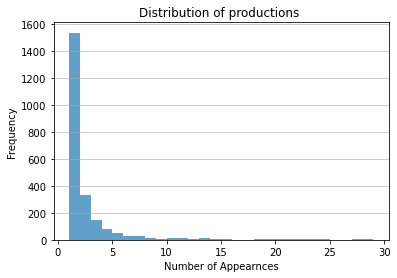

In [46]:
pcfg200_cnf=pcfg_cnf_learn(treebank, 200)
get_statistics(pcfg200_cnf,200)

<a name="q2.4"></a>
<h3>Question 2.4: Test CFG Independence Assumptions</h3>

We want to test the CFG hypothesis that a node expansion is independent from its location within a tree.
<p/>

For the treebank before CNF transformation, report the following statistics, for the expansions of the NP category:
<ul>
<li>Compute the distribution of the RHS given the NP LHS for all NPs in the treebank.  Draw a histogram plot.
<li>Compute the same distribution only for NPs that appear directly below a S node (any variant of S in the Penn treebank tagset). Draw a histogram plot.
<li>Compute the same distribution only for NPs that appear directly below a VP node (any variant of VP in the Penn Treebank tagset). Draw a histogram plot. 
<li>Compare the distributions above.  Use KL-divergence.
<li>Conclude: does the data in the treebank confirm the CFG hypothesis for each configuration (original trees, annotated CNF trees)? 
    (How do you calibrate the values of the KL-divergence to decide that 2 values are similar?)
</ul>
<p/>


In [47]:
def dist_rhs_given_lhs(treebank, n, rule, lhs=None):
    tree_productions = []
    found_lhs= lhs==None
    for i in range(n):
        tree = treebank.parsed_sents()[i]
        products = tree_to_productions(tree)
        for p in products:
            if p.lhs() == rule and found_lhs:
                tree_productions.append(p.rhs())
                if lhs is not None:
                    found_lhs = False
            if lhs is not None:
                if p.lhs() == lhs:
                    found_lhs = True
    prodcutions_counts = Counter(tree_productions)
    freq = []
    for p in prodcutions_counts:
        freq.append(prodcutions_counts[p])
    return freq, prodcutions_counts,tree_productions

In [44]:
import numpy as np
def check_rhs(lhs_string,min_val):
    lhs=Nonterminal(lhs_string)
    lhs_freq, counts,tree_productions = dist_rhs_given_lhs(treebank, 200, lhs)
    filtered = { k: v for k, v in counts.items() if v >= min_val }
    print(make_bold("Count before transformation:"),len(counts))
    print(make_bold("After transformation: "),len(filtered))
    
    y_pos = np.arange(len(tuple(filtered.keys())))
    performance = filtered.values()
    plt.bar(y_pos, performance)
    plt.xticks(y_pos, tuple(filtered.keys()))
    plt.ylabel('occurrences')
    plt.title(f'Distribution below {lhs_string}')
    plt.show()
    return tree_productions

We filtered the NP with leth then a certain value so we can see the histogram clearer

Count before transformation: 268
After transformation:  8


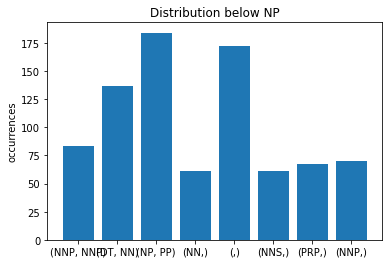

In [49]:
production_np=check_rhs('NP',60)

Count before transformation: 52
After transformation:  6


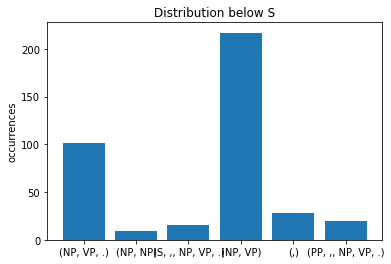

In [50]:
production_s=check_rhs('S',8)

Count before transformation: 169
After transformation:  8


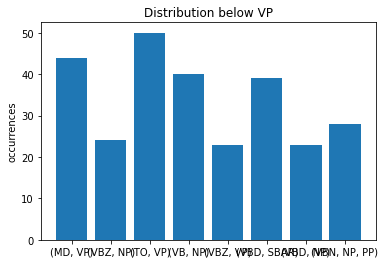

In [51]:
production_vp=check_rhs('VP',20)

In [109]:
def prods_per_lhs2(lhs,productions):
    return [p for p in productions if p[0]==lhs and len(p)>1]

In [114]:
import math
def compute_KL2(prods_origin,prods_sampled):
    kl_total=0
    epsilon = 0.0001
    for lhs in lcount:
        kl=0
        lhs_productions_sample=prods_per_lhs2(lhs,prods_sampled.samples())
        if lhs_productions_sample==[]:
            continue
        lhs_productions_origin=prods_per_lhs2(lhs, prods_origin.samples())
        qc = (len(lhs_productions_origin) - len(lhs_productions_sample)) * epsilon / len(lhs_productions_sample)

        for origin_prod in lhs_productions_origin:
            p = origin_prod.prob()-pc
            sampled_prod = next((prod for prod in lhs_productions_sample 
                                 if prod[0] == origin_prod[0]
                                 and len(prods)>1 and lenf(origin_prod)
                                 and prod[1] == origin_prod[1]), None)
            if sampled_prod == None:
                q = epsilon
            else:
                q = sampled_prod.prob()-qc
            
            kl += q * abs(math.log(q/p))
        
        kl_total+=kl    
        print(make_bold("lhs: "), lhs,make_bold("| kl-divergence: "), kl)

You can ignore the next plots, we just want the whole production_np no filtering

In [133]:
compute_KL2(MLEProbDist(FreqDist(production_vp)),MLEProbDist(FreqDist(production_np)))
compute_KL2(MLEProbDist(FreqDist(production_vp)),MLEProbDist(FreqDist(production_s)))

lhs:  NP | kl-divergence:  0
lhs:  S | kl-divergence:  0
lhs:  NP | kl-divergence:  0
lhs:  PP | kl-divergence:  0


For some reason we got that the kl-divergence is zero - it may be great or something went wrong in our computation

<hr/>
<a name="q3"></a>
<h2>Question 3: Building and Evaluating a Simple PCFG Parser</h2>

In this question, we will construct a Viterbi parser for the PCFG induced in Question 2 and perform evaluation of this statistical parser. 
<p/>

<a name="q3.1"></a>
<h3>Question 3.1: Build a Parser</h3>

<a name="q3.1.1"></a>
<h4>3.1.1 Dataset Split</h4>
    
Split the NLTK treebank corpus into 80% training (about 3,200 trees) and 20% (about 800 trees) testing sets.
<p/>

In [9]:
from nltk.corpus import treebank
trees = treebank.parsed_sents()

# print tagged_sentences[0]
print("Trees corpus: ", len(trees))

# Split the dataset for training and testing
cut = int(0.8 * len(trees))
train_trees = trees[:cut]
test_trees = trees[cut:]

print("Trees in train: ", len(train_trees))
print("Trees in test: ", len(test_trees))

Trees corpus:  3914
Trees in train:  3131
Trees in test:  783


<a name="q3.1.2"></a>
<h4>3.1.2 Learn a PCFG over the Chomsky Normal Form version of this treebank</h4>
<p/>

In [12]:
pcfg_cnf = pcfg_cnf_learn(train_trees, len(train_trees),True)

total prods: 170191
unique prods: 17308


<a name="q3.1.3"></a>
<h4>3.1.3 Viterbi Parser</h4>
    
Construct a <code><a href="https://www.nltk.org/_modules/nltk/parse/viterbi.html">ViterbiParser</a></code> using this PCFG grammar.
Test the parser on a few sentences.

In [13]:
from nltk.parse import ViterbiParser
parser = ViterbiParser(pcfg_cnf)

In [53]:
sentences= []
for i in range(5):
    sentences.append(treebank.sents()[i])
[print(s,"\n-----------") for s in sentences]

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 
-----------
['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Elsevier', 'N.V.', ',', 'the', 'Dutch', 'publishing', 'group', '.'] 
-----------
['Rudolph', 'Agnew', ',', '55', 'years', 'old', 'and', 'former', 'chairman', 'of', 'Consolidated', 'Gold', 'Fields', 'PLC', ',', 'was', 'named', '*-1', 'a', 'nonexecutive', 'director', 'of', 'this', 'British', 'industrial', 'conglomerate', '.'] 
-----------
['A', 'form', 'of', 'asbestos', 'once', 'used', '*', '*', 'to', 'make', 'Kent', 'cigarette', 'filters', 'has', 'caused', 'a', 'high', 'percentage', 'of', 'cancer', 'deaths', 'among', 'a', 'group', 'of', 'workers', 'exposed', '*', 'to', 'it', 'more', 'than', '30', 'years', 'ago', ',', 'researchers', 'reported', '0', '*T*-1', '.'] 
-----------
['The', 'asbestos', 'fiber', ',', 'crocidolite', ',', 'is', 'unusually', 'resilient', 'once', 'it', 'enters', 'the', '

[None, None, None, None, None]

The parsing took a lot of time per sentece so we will check only on 2 sentence

In [54]:
parsed, = parser.parse(sentences[0])

In [55]:
print(parsed)

(S
  (NP^<S>
    (NP^<NP> (NNP Pierre) (NNP Vinken))
    (NP|<,>^<S>
      (, ,)
      (NP|<ADJP>^<S>
        (ADJP^<NP>
          (NP^<ADJP> (CD 61) (NNS years))
          (JJ old))
        (, ,))))
  (S|<VP>
    (VP^<S>
      (MD will)
      (VP^<VP>
        (VB join)
        (VP|<NP>^<VP>
          (NP^<VP>
            (NP^<NP> (DT the) (NN board))
            (PP^<NP>
              (IN as)
              (NP^<PP>
                (DT a)
                (NP|<JJ>^<PP>
                  (JJ nonexecutive)
                  (NN director)))))
          (NP^<VP> (NNP Nov.) (CD 29)))))
    (. .))) (p=1.62506e-51)


In [56]:
parsed, = parser.parse(sentences[1])
print(parsed)

(S
  (NP^<S> (NNP Mr.) (NNP Vinken))
  (S|<VP>
    (VP^<S>
      (VBZ is)
      (NP^<VP>
        (NP^<NP> (NN chairman))
        (PP^<NP>
          (IN of)
          (NP^<PP>
            (NP^<NP> (NNP Elsevier) (NNP N.V.))
            (NP|<,>^<PP>
              (, ,)
              (NP^<NP>
                (DT the)
                (NP|<JJ>^<NP>
                  (JJ Dutch)
                  (NP|<NN>^<NP> (NN publishing) (NN group)))))))))
    (. .))) (p=8.67746e-37)


<a name="q3.2"></a>
<h3>Question 3.2: Evaluate the Parser</h3>

Your task is to compute the ParsEval metric for the constituent-based parse trees on the test dataset of our treebank.  
Report the following metrics:
<ol>
<li>Precision
<li>Recall
<li>F-measure
<li>Labelled Precision
<li>Labelled Recall
<li>Labelled F-Measure
</ol>

Where precision and recall are computed over "constituents" between the parsed trees and the treebank trees: a constituent is a triplet 
(interior_node, first_index, last_index) - where first_index is the index of the first word in the sentence covered by the interior node,
and last_index that of the last word (that is, [first_index, last_index] is the yield of the interior node).
<p/>

In labelled precision and recall we count that 2 constituents match if they have the same label for the interior node.  
For unlabelled metrics, we just compare the first and last indexes.  
Make sure you compare the trees from the treebank after they have been simplified: for example, S-TPC-1 must be compared with S and ADVP-TMP with ADVP, and -NONE- nodes have been eliminated.
<p/>

You can read more on this metric in the following references:
<ol>
<li><a href="http://courses.washington.edu/ling571/ling571_fall_2010/slides/evalb_improved_pcky.pdf">An assignment on parsing evaluation by Scott Farrar</a> includes detailed explanation and examples on how the metric is computed.
<li><a href="http://nlp.cs.nyu.edu/evalb/">Evalb</a> software: this is the C program used in all standard evaluations of constituent parsers (by Satoshi Sekine and Michael  Collins).
<li><a href="http://nlp.stanford.edu/nlp/javadoc/javanlp/edu/stanford/nlp/parser/metrics/Evalb.html">Evalb in Java</a> for those who prefer reading Java over C - is part of the Stanford CoreNLP package.
</ol>

The specific steps to follow are:
<ul>
<li>Generate a list of labelled constituents of the form <code>[label first_index last_index]</code> given a parse tree.</li>
<li>Compute unlabelled Precision, Recall and F-measure for your parser on the test dataset</li>
<li>Compute labelled Precision, Recall and F-measure for your parser on the test dataset</li>
</ul>

In [14]:
def labelled_constituents(tree, constituents_lst, first, last):
    if not constituents_lst:
        constituents_lst.append([tree.label(), first, last])
    if len(list(tree.subtrees())) == 1:
        return [tree.label(), first, last]
    else:
        for subtree in tree:
            new_last = first+len(subtree.leaves())-1
            label = [subtree.label(), first, new_last]
            labelled_constituents(subtree, constituents_lst, first, new_last)
            first += len(subtree.leaves())
            last += len(subtree.leaves())
            constituents_lst.append(label)
        return constituents_lst
    

def get_labelled_constituents(tree):
    constituents = []
    return labelled_constituents(tree, constituents, 0, len(tree.leaves())-1)

Lets check get_labelled_constituents on the parsed sentence we parsed above

In [58]:
get_labelled_constituents(parsed)

[['S', 0, 12],
 ['NNP', 0, 0],
 ['NNP', 1, 1],
 ['NP^<S>', 0, 1],
 ['VBZ', 2, 2],
 ['NN', 3, 3],
 ['NP^<NP>', 3, 3],
 ['IN', 4, 4],
 ['NNP', 5, 5],
 ['NNP', 6, 6],
 ['NP^<NP>', 5, 6],
 [',', 7, 7],
 ['DT', 8, 8],
 ['JJ', 9, 9],
 ['NN', 10, 10],
 ['NN', 11, 11],
 ['NP|<NN>^<NP>', 10, 11],
 ['NP|<JJ>^<NP>', 9, 11],
 ['NP^<NP>', 8, 11],
 ['NP|<,>^<PP>', 7, 11],
 ['NP^<PP>', 5, 11],
 ['PP^<NP>', 4, 11],
 ['NP^<VP>', 3, 11],
 ['VP^<S>', 2, 11],
 ['.', 12, 12],
 ['S|<VP>', 2, 12]]

In [15]:
def tree_to_sentence(tree):
    sentence = ""
    if isinstance(tree, Tree):
        for subtree in tree:
            sentence += tree_to_sentence(subtree)
    else:
        sentence += tree + ' '
    return sentence

We encounter few problems while trying to parse the test data:
First, There are some words in test that does not appear in tain , so the parser throws us exceptions.
Second, The parsing time was too long , so we filtered terminal rules which produce words that not in test.

In [16]:
def update_productions (train_words,test_words,productions):
#     add words in treebank that not in test
    for word, tag in treebank.tagged_words():
        if word not in train_words:
            productions.append(Tree.fromstring(f'({tag} {word})').productions()[0])
    return productions

In [17]:
def get_word_in_tree(tree):
    words=[]
    for sub in tree.subtrees():
        if len(sub)==1:
            for p in sub.productions():
                words.append(p.rhs()[0])
    return words

def get_all_words_in_trees(trees):
    words = []
    for tree in trees:
        words +=get_word_in_tree(tree)
    return set(words)

In [30]:
train_words=get_all_words_in_trees(train_trees)
test_words=get_all_words_in_trees(test_trees)

In [31]:
updated_productions=update_productions(train_words,test_words,pcfg_cnf.productions())

Let see the number of production now

In [33]:
len(updated_productions)

19250

we update the parser to include the new words

In [34]:
pcfg_new = nltk.grammar.induce_pcfg(nltk.grammar.Nonterminal('S'), updated_productions)
parser = ViterbiParser(pcfg_new)

In [37]:
test_sents=[tree_to_sentence(tree).split() for tree in test_trees]

In [69]:
print(test_sents[0])

['The', 'latest', '10-year', 'notes', 'were', 'quoted', 'at', '100', '22\\/32', '*-1', 'to', 'yield', '7.88', '%', 'compared', 'with', '100', '16\\/32', '*', 'to', 'yield', '7.90', '%', '.']


We could parse the sentes

In [70]:
p=parser.parse_all(test_sents[0])

In [71]:
for x in p:
    print(get_labelled_constituents(x))

[['S', 0, 23], ['DT', 0, 0], ['JJS', 1, 1], ['CD', 2, 2], ['NNS', 3, 3], ['NP|<CD>^<S>', 2, 3], ['NP|<JJS>^<S>', 1, 3], ['NP^<S>', 0, 3], ['VBD', 4, 4], ['VBN', 5, 5], ['IN', 6, 6], ['CD', 7, 7], ['CD', 8, 8], ['QP|<CD>^<NP>', 7, 8], ['QP^<NP>', 6, 8], ['', 9, 9], ['NP^<ADJP>', 6, 9], ['TO', 10, 10], ['NN', 11, 11], ['CD', 12, 12], ['NP^<S>', 11, 12], ['JJ', 13, 13], ['VBN', 14, 14], ['IN', 15, 15], ['CD', 16, 16], ['CD', 17, 17], ['', 18, 18], ['NP|<CD>^<PP>', 17, 18], ['NP^<PP>', 16, 18], ['TO', 19, 19], ['NN', 20, 20], ['CD', 21, 21], ['NN', 22, 22], ['NP|<CD>^<PP>', 21, 22], ['NP^<PP>', 20, 22], ['PP^<PP>', 19, 22], ['PP|<NP>^<PP>', 16, 22], ['PP^<PP>', 15, 22], ['PP^<PP>', 14, 22], ['PP^<S>', 13, 22], ['S^<PP>', 11, 22], ['PP^<ADJP>', 10, 22], ['ADJP|<NP>^<VP>', 6, 22], ['ADJP^<VP>', 5, 22], ['VP^<S>', 4, 22], ['.', 23, 23], ['S|<VP>', 4, 23]]


In [18]:
# We saved the parsed trees in a pickle file so we can use without wating the entire time 
import pickle 
with open ('parse', 'rb') as fp:
    parsed = pickle.load(fp)

In [72]:
# to reduce the computation time we use parallel computation
import multiprocessing as mp
constituents = []
with mp.Pool() as pool:
    parsed = pool.map(parser.parse_all,test_sents)

In [19]:
# get parsed_tree constituents
def create_constituents():
    constituents = []
    for parsed_sentence in parsed:
        for t in parsed_sentence:
            constituents.append(get_labelled_constituents(t))
    return constituents

In [20]:
constituents=create_constituents()

In [21]:
def create_constituents_treebank():
    constituents_treebank = []
    for tree in test_trees:
        constituents_treebank.append(get_labelled_constituents(tree))
    return constituents_treebank

In [22]:
constituents_treebank = create_constituents_treebank()

In [31]:
# labelled: n=1, unlabelled: n=0
import re, string
import numpy as np

def precision_recall(parsed_constituents, treebank_constituents, n):
    precision = []
    recall = []
    correct_constituents = 0
    for num in range(len(parsed_constituents)):
        label_parser = parsed_constituents[num]
        label_treebank = treebank_constituents[num]
        correct = 0
        total_constituents = len(label_parser)
        correct_constituents_reference = len(label_treebank)
        for index in range(len(label_parser)):
            if(index>=len(label_treebank)):
                break
            lp0=re.split("[" + string.punctuation + "]+", label_parser[index][0])[0]
            lt0=re.split("[" + string.punctuation + "]+", label_parser[index][0])[0]
            if  n==1 and (label_parser[index][1] == label_treebank[index][1]):
                correct += 1
            elif n==0 and lp0==lt0 and (label_parser[index][2] == label_treebank[index][2]):
                correct += 1
        precision.append(correct / total_constituents) 
        recall.append(correct / correct_constituents_reference)
    precision = np.mean(precision)
    recall = np.mean(recall)
    f_measure = (2 * precision * recall) / (precision + recall)
    return precision, recall, f_measure

In [32]:
# labelled
laballed_result = precision_recall(constituents, constituents_treebank,1)
print('Overall result for labelled constituents:')
print(f'precision: {laballed_result[0]}')
print(f'recall: {laballed_result[1]}')
print(f'f-measure: {laballed_result[2]}')

Overall result for labelled constituents:
precision: 0.654222591934324
recall: 0.7892820036245879
f-measure: 0.7154339788969805


We can tell that the results are not so great, lets check for unlabelled

In [33]:
# unlabelled
unlaballed_result = precision_recall(constituents, constituents_treebank, 0)
print('Overall result for unlabelled constituents:')
print(f'precision: {unlaballed_result[0]}')
print(f'recall: {unlaballed_result[1]}')
print(f'f-measure: {unlaballed_result[2]}')

Overall result for unlabelled constituents:
precision: 0.7510198181051322
recall: 0.9042256988565073
f-measure: 0.8205325589737732


<a name="q3.3"></a>
<h3>Question 3.3: Accuracy per Distance</h3>

In general, parsers do a much better job on short constituents than long ones.  
Draw a plot of the accuracy of constituents per constituent length.  
The length of a constituent (node, first, last) is last-first+1.  
For a given constituent length X, accuracy is the number of constituents 
of length X in the parsed tree that are accurate divided by the total number of constituents of length X.

In [128]:
import re, string
def get_accuracy_by(parsed_constituents, treebank_constituents,acc_type):
    dic = {}
    for index in range(len(parsed_constituents)):
        label_parsed = parsed_constituents[index]
        label_tree = treebank_constituents[index]
        for index2 in range(len(parsed_constituents)):
            try:
                if(acc_type=='distance'):
                    key= label_tree[index2][2] - label_tree[index2][1] + 1
#                 by label
                else:
                    key =label_tree[index2][0].split('-')[0]
                if str(key) not in dic:
                    dic[str(key)] = [0, 1]
                else:
                    dic[str(key)][1] += 1
                
                lp=re.split("[" + string.punctuation + "]+", label_parsed[index2][0])[0]
                lt=re.split("[" + string.punctuation + "]+", label_parsed[index2][0])[0]
#                 print(label_parsed[index2][0],"==" ,label_tree[index2][0] )
                if lp == lt:
                    dic[str(key)][0] += 1
            except Exception as e:
                continue
    return dic

In [175]:
def plot_acc(acc,acc_type,labels=None):
    x = list()
    y = list()
    for k, v in acc.items():
        if labels==None or k in labels:
            if(acc_type=='distance'):
                x.append(int(k))
            else:
                x.append(k)
            
            y.append(v[0] / v[1]) 
    plt.bar(x,y)

In [132]:
acc_by_distance=get_accuracy_by(constituents, constituents_treebank,'distance')

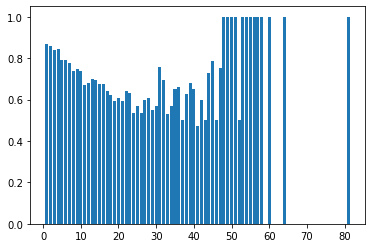

In [133]:
plot_acc(acc_by_distance,'distance')

we can tell that from a distance larger than 50 we get perfect accuracy

let look at the accuracy in [0,50]

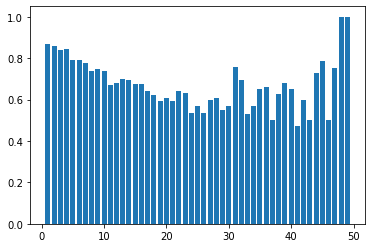

In [176]:
plot_acc(acc_by_distance,'distance',[str(x) for x in range(50)])

<a name="q3.4"></a>
<h3>Question 3.4: Accuracy per Label</h3>

Report accuracy of constituents per label type (S, SBAR, NP, VP, PP etc).
For each node type, report number of occurrences and accuracy. 
Note: report accuracy per node type WITHOUT Chomsky Normal Form modification.
For example, if the CNF of the tree generated a non-terminal NP^S, we should count this as NP for this question.

In [129]:
acc_by_label=get_accuracy_by(constituents, constituents_treebank,'label')

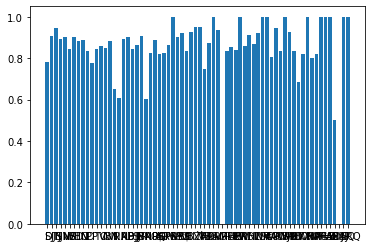

In [165]:
plot_acc(acc_by_label,'labels')

We can't really see anything, lets try to look at specific labels

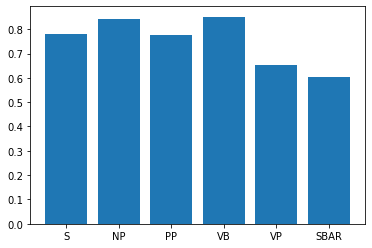

In [164]:
labels = ["S", "NP", "VB","VP", "PP","SBAR","PP"]
plot_acc(acc_by_label,'labels',labels)

END